In [44]:
import matplotlib.pyplot as plt
import os 
import tensorflow as tf
print(tf.__version__)

2.2.0


There are actually a few ways of saving and loading models TensorFllow such as only saving the parameters or the weights of a model or saving the entire model including the architecture. You can also save the architecture only without the weights.

## LOAD DATA 

**CIFAR-10 dataset**

The CIFAR-10 dataset consists of, in total, 60000 color images, each with one of 10 labels: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. For an introduction and a download, see this link.

Shpae of x: (10000, 32, 32, 3), type: <class 'numpy.ndarray'>


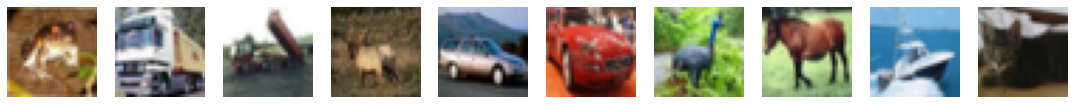

In [17]:
def show_data(x):
    fig, ax = plt.subplots(1, 10, figsize=(19, 3))
    for i in range(10):
        ax[i].set_axis_off()
        ax[i].imshow(x[i])
        
    print(f"Shpae of x: {x.shape}, type: {type(x)}")
        

# Import the CIFAR-10 dataset and rescale the pixel values
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# Use smaller subset -- speeds things up
x_train = x_train[:10000]
y_train = y_train[:10000]
x_test = x_test[:1000]
y_test = y_test[:1000]

show_data(x_train)

Notice that this time we are given a data set of (32,32,3) meaning that we dont have to reshape to add an extra channel.
## Define Model

In [41]:
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(32,32,3)))
    model.add(tf.keras.layers.Conv2D(filters=16,kernel_size=(3,3),activation="relu",name='conv1'))
    model.add(tf.keras.layers.Conv2D(filters=8,kernel_size=(3,3),activation="relu",name="conv2"))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(4,4),name="pool1"))
    model.add(tf.keras.layers.Flatten(name="flatten"))
    model.add(tf.keras.layers.Dense(units=32,activation="relu",name="dense1"))
    model.add(tf.keras.layers.Dense(units=10,activation="softmax",name="dense2"))
    return model
    
def compile_model(model):
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    
def train_model(model,x,y,epochs,**kwargs):
    return model.fit(x=x, y=y,epochs=epochs,**kwargs)
    
def get_test_accuracy(model, x, y):
    test_loss, test_acc = model.evaluate(x=x, y=y, verbose=0)
    print("------------------------------------------------")
    print('Model accuracy: {acc:0.3f}'.format(acc=test_acc))
    print("------------------------------------------------")

In [42]:
model = get_model()  # Define model
compile_model(model) # Compile model
model.summary()      # Display summary of model
get_test_accuracy(model, x_test, y_test)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 30, 30, 16)        448       
_________________________________________________________________
conv2 (Conv2D)               (None, 28, 28, 8)         1160      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 7, 7, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 392)               0         
_________________________________________________________________
dense1 (Dense)               (None, 32)                12576     
_________________________________________________________________
dense2 (Dense)               (None, 10)                330       
Total params: 14,514
Trainable params: 14,514
Non-trainable params: 0
__________________________________________________

## Overview of saving with tf:
`tf.keras.callbacks.ModelCheckpoint` callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

Here is a list of some usefull arguments:
* **monitor** (string): quantity to monitor.


* **save_best_only** (boolean): if True, Saves the latest best model according to the quantity monitored 


* **mode** (auto,min,max): If True, the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity.


* **save_freq** ('epoch' or int): When using 'epoch', the callback saves the model after each epoch. When using integer, the callback saves the model at end of this many batches


* **save_weights_only** (boolean): if True, then only the model's weights will be saved else the full model is saved.

If you wish you can modify the filepath  in order to save many files for different batch iterations:

`path = checpoint_{epochs:02d}{batch:04d}`

##  1.A) Saving Weights
To  only save the weights of the model is as simple as declearing  `save_weights_only=True` inside `tf.keras.callbacks.ModelCheckpoint` callback 

In [51]:
### Define Callback ###
path = 'Saved_model/chekpoint' # path to save model
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=path, frequency='epoch',save_weights_only=True,verbose=2)

### Train Model and Save ##
history =train_model(model,x_train,y_train,epochs=3,callbacks=[checkpoint])
get_test_accuracy(model, x_test, y_test)

Epoch 1/3
312/313 [============================>.] - ETA: 0s - loss: 1.4466 - accuracy: 0.4775
Epoch 00001: saving model to Saved_model/chekpoint
313/313 [==============================] - 17s 55ms/step - loss: 1.4470 - accuracy: 0.4775
Epoch 2/3
312/313 [============================>.] - ETA: 0s - loss: 1.3931 - accuracy: 0.5019
Epoch 00002: saving model to Saved_model/chekpoint
313/313 [==============================] - 15s 47ms/step - loss: 1.3925 - accuracy: 0.5023
Epoch 3/3
312/313 [============================>.] - ETA: 0s - loss: 1.3290 - accuracy: 0.5266
Epoch 00003: saving model to Saved_model/chekpoint
313/313 [==============================] - 16s 53ms/step - loss: 1.3288 - accuracy: 0.5263
------------------------------------------------
Model accuracy: 0.520
------------------------------------------------


In [52]:
### Lets take a look to the files that were generated at Saved_models ###
os.listdir("Saved_model")

['checkpoint', 'chekpoint.data-00000-of-00001', 'chekpoint.index']

**So, what are each of these files?**

#### `checkpoint`
This file is by far the smallest, at only 87 bytes. It's actually so small that we can just look at it directly. It's a human readable file with the following text:
```
model_checkpoint_path: "checkpoint"
all_model_checkpoint_paths: "checkpoint"
```
This is metadata that indicates where the actual model data is stored.

#### `checkpoint.index`
This file tells TensorFlow which weights are stored where. When running models on distributed systems, there may be different *shards*, meaning the full model may have to be recomposed from multiple sources. In the last notebook, you created a single model on a single machine, so there is only one *shard* and all weights are stored in the same place.

#### `checkpoint.data-00000-of-00001`
This file contains the actual weights from the model. It is by far the largest of the 3 files. Recall that the model you trained had around 14000 parameters, meaning this file is roughly 12 bytes per saved weight.

## 1.B) Loading Weights
In order to load weights we can use the `model.load_weights(filepath='path')` method. Let's try it out

In [54]:
## Define new model ###
new_model = get_model()  
compile_model(new_model)
### Get accuracy to validate it is Model is not trained ###
get_test_accuracy(new_model, x_test, y_test)

### Load weights ###
new_model.load_weights(filepath='Saved_model/chekpoint')

### Get accuracy to validate it is Model has trained  weights###
get_test_accuracy(new_model, x_test, y_test)

------------------------------------------------
Model accuracy: 0.132
------------------------------------------------
------------------------------------------------
Model accuracy: 0.520
------------------------------------------------


## 2.A) Saving the entire model
To save the entire model is as simple as declearing  `save_weights_only=False` inside `tf.keras.callbacks.ModelCheckpoint` callback 

In [55]:
### Define Callback ###
path = 'Saved_model/model_chekpoint' # path to save model
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=path, frequency='epoch',save_weights_only=False,verbose=2)

### Train Model and Save ##
history =train_model(model,x_train,y_train,epochs=3,callbacks=[checkpoint])
get_test_accuracy(model, x_test, y_test)

Epoch 1/3
312/313 [============================>.] - ETA: 0s - loss: 1.2695 - accuracy: 0.5491
Epoch 00001: saving model to Saved_model/model_chekpoint
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Saved_model/model_chekpoint\assets
313/313 [==============================] - 17s 55ms/step - loss: 1.2693 - accuracy: 0.5492
Epoch 2/3
312/313 [============================>.] - ETA: 0s - loss: 1.2273 - accuracy: 0.5712 ETA
Epoch 00002: saving model to Saved_model/model_chekpoint
INFO:tensorflow:Assets written to: Saved_model/model_chekpoint\assets
313/313 [==============================] - 17s 53ms/step - loss: 1.2274 - accuracy: 0.5710
Epoch 3/3
312/313 [============================>.] - ETA: 0s - loss: 1.1817 - accuracy: 0.5771
Epoch 00003: saving model to Saved_model/model_chekpoint
INFO:tensorflow:Assets written to: Saved_model/model_chekpoint\assets
313/313 [==============================] - 16s 52ms/step - loss: 1.

Contrary to the prevous example when we only saved the weights. When we saved a model we create a new Directory to save the same files as in weights, plus some more

## 2.B) Loading the entire model
In order to load the model we can use the `tf.keras.models.load_model(filepath="path")` method 

In [59]:
### delete model ###
del model  

### load Model ###
model =tf.keras.models.load_model(filepath='Saved_model/model_chekpoint' )
compile_model(model)

### Get accuracy to validate it is Model has trained  weights###
get_test_accuracy(model, x_test, y_test)

------------------------------------------------
Model accuracy: 0.532
------------------------------------------------
